In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import drive
import os
import zipfile

zip_folder = '/content/drive/MyDrive/AIML Audio Processing/audio_data'
destination = '/content/drive/MyDrive/AIML Audio Processing/data'  # where files will be extracted

# Create destination folder if not exists
os.makedirs(destination, exist_ok=True)


zip_files = ['Audio_Song_Actors_01-24.zip', 'Audio_Speech_Actors_01-24.zip']

for zip_file in zip_files:
    zip_path = os.path.join(zip_folder, zip_file)
    print(f"Unzipping: {zip_file}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination)

print("Unzipping complete. Files are in:", destination)


Unzipping: Audio_Song_Actors_01-24.zip
Unzipping: Audio_Speech_Actors_01-24.zip
Unzipping complete. Files are in: /content/drive/MyDrive/AIML Audio Processing/data


In [7]:
!pip install keras tensorflow


In [8]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

In [9]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [15]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio files into a numpy array.
    Parameters
    ----------
    data : np.ndarray - audio time series
    sr : int - sampling rate
    mfcc : bool - extract MFCCs
    chroma : bool - extract Chroma features
    mel : bool - extract Mel Spectrogram
    Returns
    -------
    np.ndarray - concatenated features
    """
    result = np.array([])

    if chroma or mel:
        stft = np.abs(librosa.stft(y=data))

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    if chroma:
        chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma_feat))

    if mel:
        mel_feat = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel_feat))

    return result


In [11]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [12]:


def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data



In [13]:
import os
import glob
import librosa
import numpy as np


data_directory = '/content/drive/MyDrive/AIML Audio Processing/data'



def load_data(save=False):
    x, y = [], []


    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        data, sr = librosa.load(file)

        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]  # Extract emotion label
        y.append(emotion)

        # Augment: Add noise
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # Augment: Shift audio
        s_data = shift(data, sr, 0.25, 'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save:
        np.save('X.npy', np.array(x))
        np.save('y.npy', y)

    return np.array(x), y


In [16]:


X, y = load_data(save=True)

# X = np.load("X.npy")
# y = np.load("y.npy")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)



In [17]:


labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)



{np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fearful'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprised'): np.int64(7)}


In [18]:


# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')



Features extracted: 180


In [20]:


from keras.models import Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from keras import regularizers
from keras.optimizers import Adam

model = Sequential()

# 1st Conv layer
model.add(Conv1D(256, 5, padding='same', input_shape=(180, 1)))
model.add(Activation('relu'))

# 2nd Conv layer
model.add(Conv1D(128, 5, padding='same',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=8))

# 3rd Conv layer
model.add(Conv1D(128, 5, padding='same',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))

# 4th Conv layer
model.add(Conv1D(128, 5, padding='same',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Flatten + Dense + Softmax
model.add(Flatten())
model.add(Dense(
    units=8,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
))
model.add(Activation('softmax'))

# Compile the model
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])




In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [22]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.2195 - loss: 2.4585 - val_accuracy: 0.3519 - val_loss: 1.8269
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.3672 - loss: 1.7790 - val_accuracy: 0.4681 - val_loss: 1.5421
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.5028 - loss: 1.4973 - val_accuracy: 0.5958 - val_loss: 1.2857
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.5724 - loss: 1.3076 - val_accuracy: 0.6012 - val_loss: 1.2345
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 380ms/step - accuracy: 0.6095 - loss: 1.2080 - val_accuracy: 0.6182 - val_loss: 1.2360
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.6278 - loss: 1.1382 - val_accuracy: 0.6542 - val_loss: 1.1027
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - accuracy: 0.6610 - loss: 1.0754 - val_accuracy: 0.6841 - val_loss: 1.0085
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 397ms/step - accuracy: 0.6887 - loss: 1.0047 - 

KeyboardInterrupt: 

In [24]:


y_pred = model.predict(XTestProcessed)



46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


<Axes: >

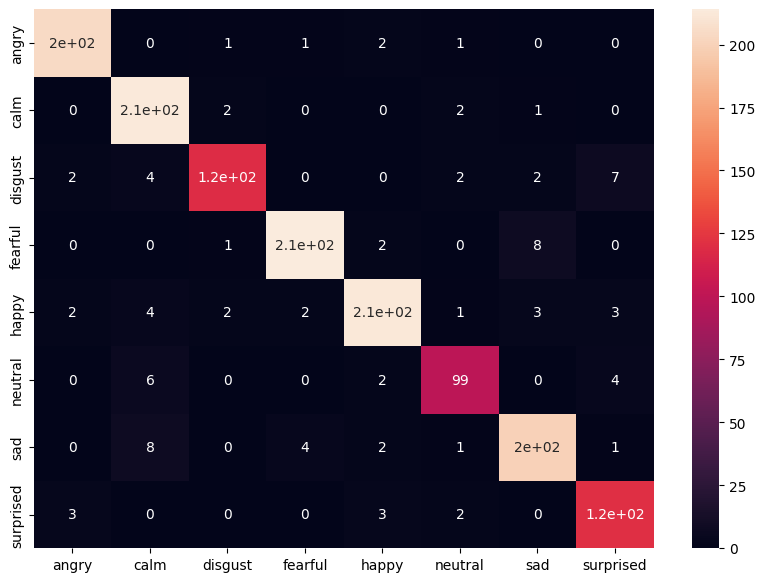

In [25]:


confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)



In [26]:
from sklearn.metrics import accuracy_score

# y_test should be in integer form, not one-hot
y_true = y_test   # ensure this is already label-encoded
y_pred_labels = np.argmax(y_pred, axis=1)

overall_acc = accuracy_score(y_true, y_pred_labels)
print(f"Overall Accuracy: {overall_acc:.2f}")


Overall Accuracy: 0.94


In [27]:
import numpy as np

# cm is your confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for {confusion_emotions[i]}: {acc:.2f}")


Accuracy for angry: 0.98
Accuracy for calm: 0.98
Accuracy for disgust: 0.88
Accuracy for fearful: 0.95
Accuracy for happy: 0.93
Accuracy for neutral: 0.89
Accuracy for sad: 0.93
Accuracy for surprised: 0.94


In [29]:


f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')



0.9380936181585567

In [31]:
model.save('ser.keras')